In [10]:
# 📦 Imports y Configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42


---

## 2. La Intuición: Dime con Quién Andas...

### El Algoritmo Más Simple Posible

```
Para clasificar un nuevo punto X:
1. Calcular la distancia de X a TODOS los puntos de entrenamiento
2. Encontrar los K puntos más cercanos (vecinos)
3. Votación: La clase mayoritaria entre los K vecinos gana
```

### Ejemplo Visual

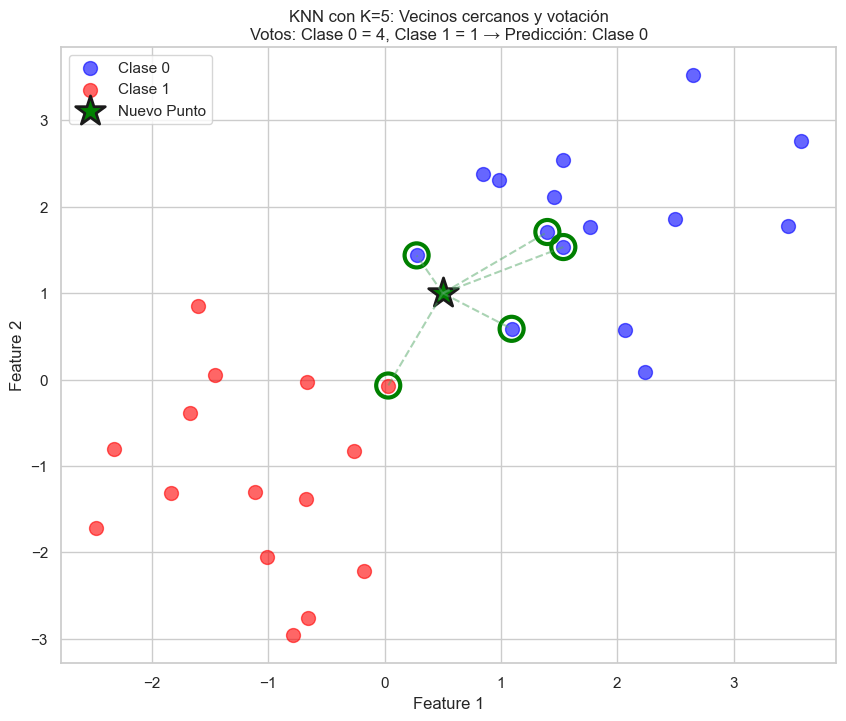

In [11]:
# Crear datos simples
np.random.seed(RANDOM_STATE)
X_simple = np.vstack([np.random.randn(15, 2) + [2, 2],
                      np.random.randn(15, 2) + [-1, -1]])
y_simple = np.array([0]*15 + [1]*15)

# Punto nuevo a clasificar
nuevo_punto = np.array([[0.5, 1]])

# Calcular distancias
distancias = np.sqrt(((X_simple - nuevo_punto)**2).sum(axis=1))

# Encontrar K=5 vecinos más cercanos
K = 5
indices_cercanos = np.argsort(distancias)[:K]

# Visualizar
plt.figure(figsize=(10, 8))
plt.scatter(X_simple[y_simple == 0, 0], X_simple[y_simple == 0, 1],
            c='blue', label='Clase 0', s=100, alpha=0.6)
plt.scatter(X_simple[y_simple == 1, 0], X_simple[y_simple == 1, 1],
            c='red', label='Clase 1', s=100, alpha=0.6)

# Punto nuevo
plt.scatter(nuevo_punto[0, 0], nuevo_punto[0, 1],
            c='green', marker='*', s=500, label='Nuevo Punto', edgecolors='k', linewidth=2)

# Dibujar líneas a los K vecinos
for idx in indices_cercanos:
    plt.plot([nuevo_punto[0, 0], X_simple[idx, 0]],
             [nuevo_punto[0, 1], X_simple[idx, 1]],
             'g--', alpha=0.5)
    plt.scatter(X_simple[idx, 0], X_simple[idx, 1],
                s=300, facecolors='none', edgecolors='green', linewidth=3)

# Conteo de votos
votos = y_simple[indices_cercanos]
prediccion = np.bincount(votos).argmax()

plt.title(f'KNN con K={K}: Vecinos cercanos y votación\n'
          f'Votos: Clase 0 = {sum(votos == 0)}, Clase 1 = {sum(votos == 1)} → Predicción: Clase {prediccion}')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


> **💡 Pro-Tip: KNN es un "Lazy Learner"**
> No hay fase de entrenamiento. Todo el trabajo se hace en predicción. Esto significa:
> - Entrenamiento: O(1) - Solo guardar datos
> - Predicción: O(n·d) - Calcular distancia a todos los n puntos en d dimensiones

---

## 3. Eligiendo K: El Parámetro Crítico

### El Tradeoff de K

| K | Comportamiento | Riesgo |
|---|----------------|--------|
| **K=1** | Clasifica igual que el vecino más cercano | Alto overfitting, sensible a ruido |
| **K pequeño** | Frontera muy irregular | Alta varianza |
| **K grande** | Frontera suave | Alto sesgo (puede ignorar patrones locales) |
| **K=n** | Siempre predice la clase mayoritaria | Modelo inútil |

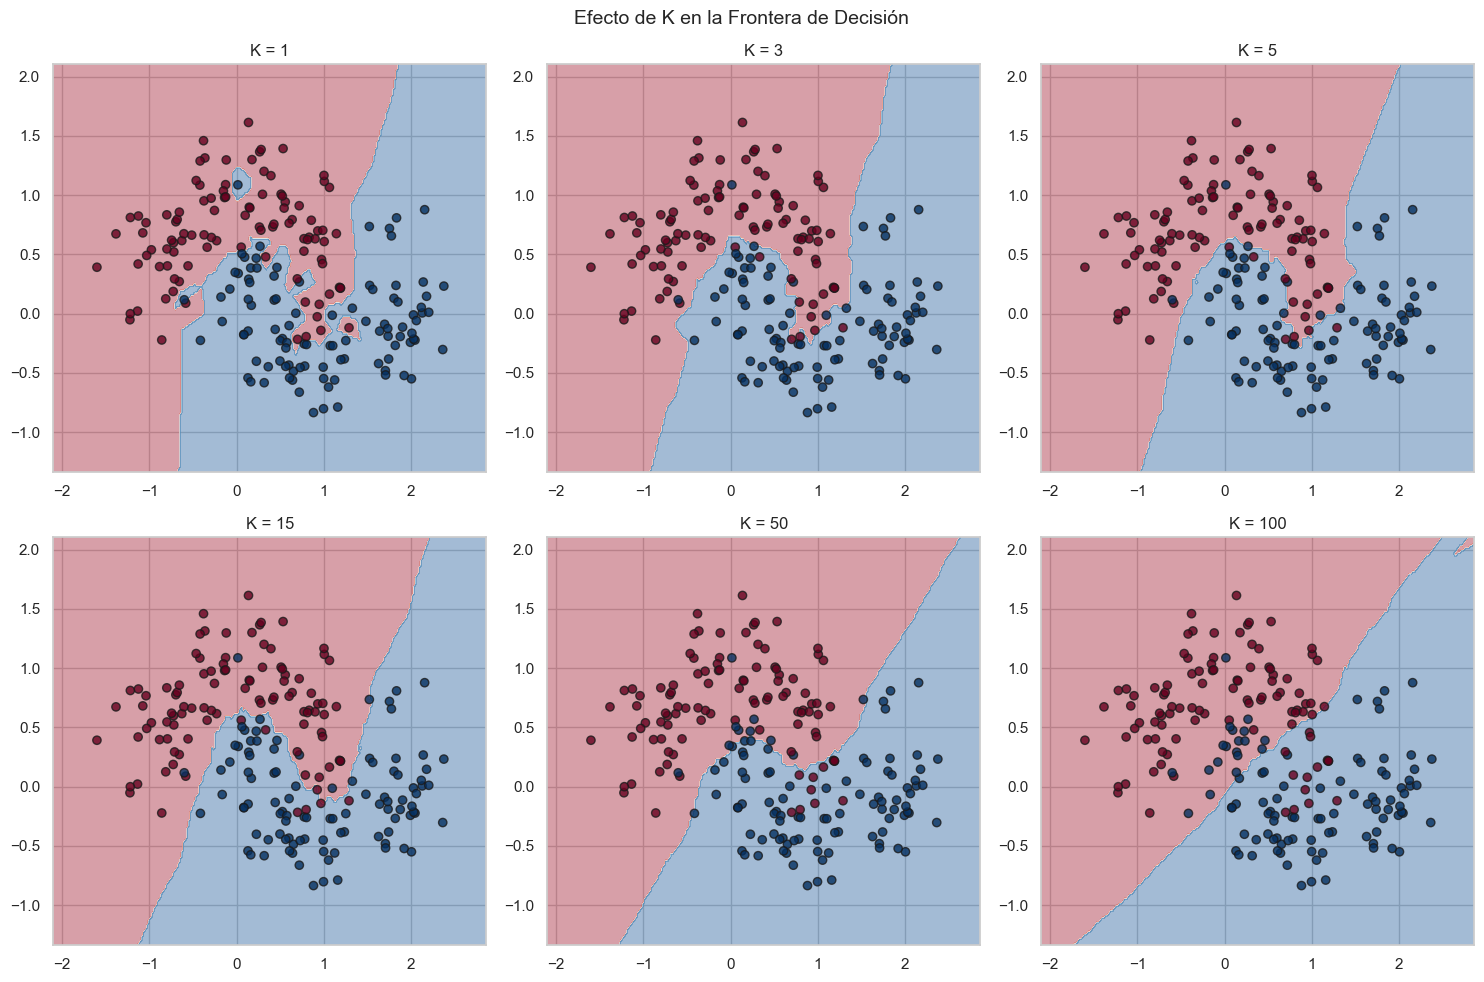

🔍 K=1: Frontera muy dentada (overfitting)
🔍 K grande: Frontera demasiado suave (underfitting)


In [12]:
# Visualizar efecto de K
X_moons, y_moons = make_moons(
    n_samples=200, noise=0.25, random_state=RANDOM_STATE)


def plot_knn_boundary(X, y, k, ax, title):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.8)
    ax.set_title(title)
    return knn.score(X, y)


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k_values = [1, 3, 5, 15, 50, 100]

for ax, k in zip(axes.flat, k_values):
    acc = plot_knn_boundary(X_moons, y_moons, k, ax, f'K = {k}')

plt.suptitle('Efecto de K en la Frontera de Decisión', fontsize=14)
plt.tight_layout()
plt.show()

print("🔍 K=1: Frontera muy dentada (overfitting)")
print("🔍 K grande: Frontera demasiado suave (underfitting)")


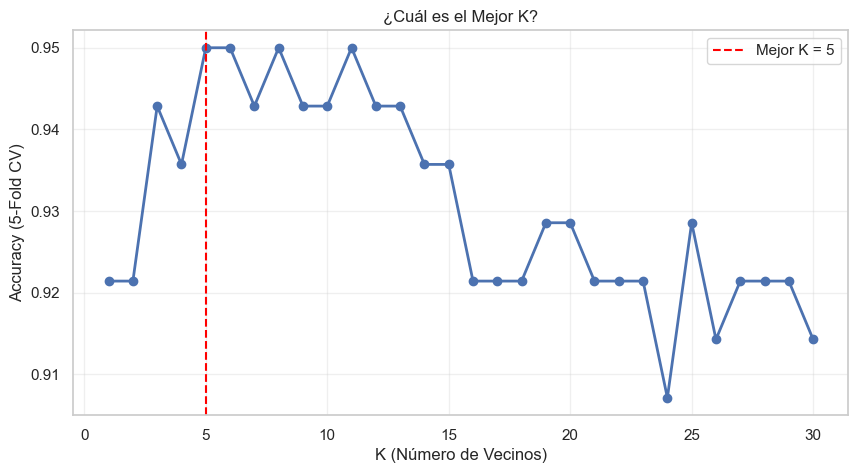

📊 Mejor K: 5
📊 Mejor CV Score: 95.00%


In [13]:
# Encontrar el mejor K con Cross-Validation
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=RANDOM_STATE)

k_range = range(1, 31)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 5))
plt.plot(k_range, cv_scores, 'o-', linewidth=2, markersize=6)
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('Accuracy (5-Fold CV)')
plt.title('¿Cuál es el Mejor K?')
plt.axvline(x=k_range[np.argmax(cv_scores)], color='red', linestyle='--',
            label=f'Mejor K = {k_range[np.argmax(cv_scores)]}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 Mejor K: {k_range[np.argmax(cv_scores)]}")
print(f"📊 Mejor CV Score: {max(cv_scores):.2%}")


> **💡 Pro-Tip: K Impar**
> Para clasificación binaria, usa K impar para evitar empates en la votación.

---

## 4. El Efecto de la Distancia

### Métricas de Distancia

| Métrica | Fórmula | Uso |
|---------|---------|-----|
| **Euclidiana (L2)** | $\sqrt{\sum(x_i - y_i)^2}$ | Default, distancia "en línea recta" |
| **Manhattan (L1)** | $\sum|x_i - y_i|$ | Cuando features tienen escalas diferentes |
| **Minkowski** | $(\sum|x_i - y_i|^p)^{1/p}$ | Generalización (p=1 Manhattan, p=2 Euclidiana) |

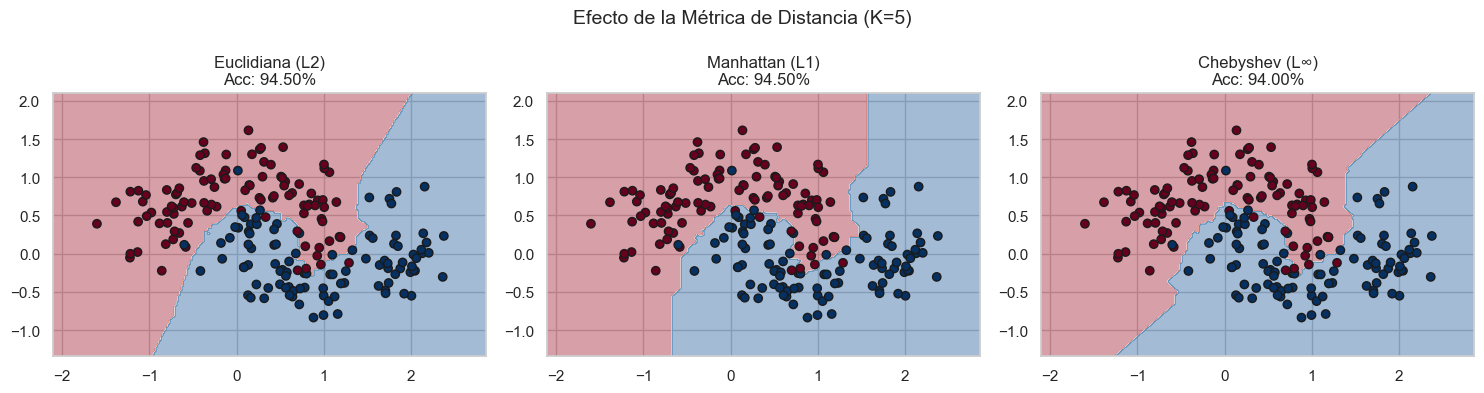

In [14]:
# Comparar métricas de distancia
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['euclidean', 'manhattan', 'chebyshev']
titles = ['Euclidiana (L2)', 'Manhattan (L1)', 'Chebyshev (L∞)']

for ax, metric, title in zip(axes, metrics, titles):
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn.fit(X_moons, y_moons)

    h = 0.02
    x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
    y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X_moons[:, 0], X_moons[:, 1],
               c=y_moons, cmap='RdBu', edgecolors='k')
    ax.set_title(f'{title}\nAcc: {knn.score(X_moons, y_moons):.2%}')

plt.suptitle('Efecto de la Métrica de Distancia (K=5)', fontsize=14)
plt.tight_layout()
plt.show()


### ⚠️ La Importancia del Escalado

Si una feature va de 0 a 1 y otra de 0 a 1,000,000, la segunda dominará la distancia.

In [15]:
# Demostración del problema de escala
np.random.seed(RANDOM_STATE)
X_scale_problem = X_moons.copy()
X_scale_problem[:, 1] = X_scale_problem[:, 1] * \
    1000  # Segunda feature escalada x1000

# Sin escalar
knn_no_scale = KNeighborsClassifier(n_neighbors=5)
scores_no_scale = cross_val_score(knn_no_scale, X_scale_problem, y_moons, cv=5)

# Con escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scale_problem)
knn_scaled = KNeighborsClassifier(n_neighbors=5)
scores_scaled = cross_val_score(knn_scaled, X_scaled, y_moons, cv=5)

print(
    f"📊 Sin escalar: {np.mean(scores_no_scale):.2%} ± {np.std(scores_no_scale):.2%}")
print(
    f"📊 Con escalar: {np.mean(scores_scaled):.2%} ± {np.std(scores_scaled):.2%}")
print("\n⚠️ ¡El escalado es CRÍTICO para KNN!")


📊 Sin escalar: 79.00% ± 4.36%
📊 Con escalar: 93.50% ± 4.06%

⚠️ ¡El escalado es CRÍTICO para KNN!


---

## 5. KNN en Acción

In [16]:
# Comparar KNN con otros algoritmos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Preparar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_moons)
X_tr, X_ts, y_tr, y_ts = train_test_split(
    X_scaled, y_moons, test_size=0.3, random_state=RANDOM_STATE)

# Modelos
models = {
    'KNN (K=5)': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE),
    'SVM (RBF)': SVC(kernel='rbf', random_state=RANDOM_STATE)
}

results = []
for name, model in models.items():
    model.fit(X_tr, y_tr)
    train_acc = model.score(X_tr, y_tr)
    test_acc = model.score(X_ts, y_ts)
    results.append(
        {'Modelo': name, 'Train Acc': train_acc, 'Test Acc': test_acc})

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


       Modelo  Train Acc  Test Acc
    KNN (K=5)   0.964286  0.950000
Decision Tree   0.985714  0.916667
Random Forest   0.992857  0.916667
    SVM (RBF)   0.907143  0.950000


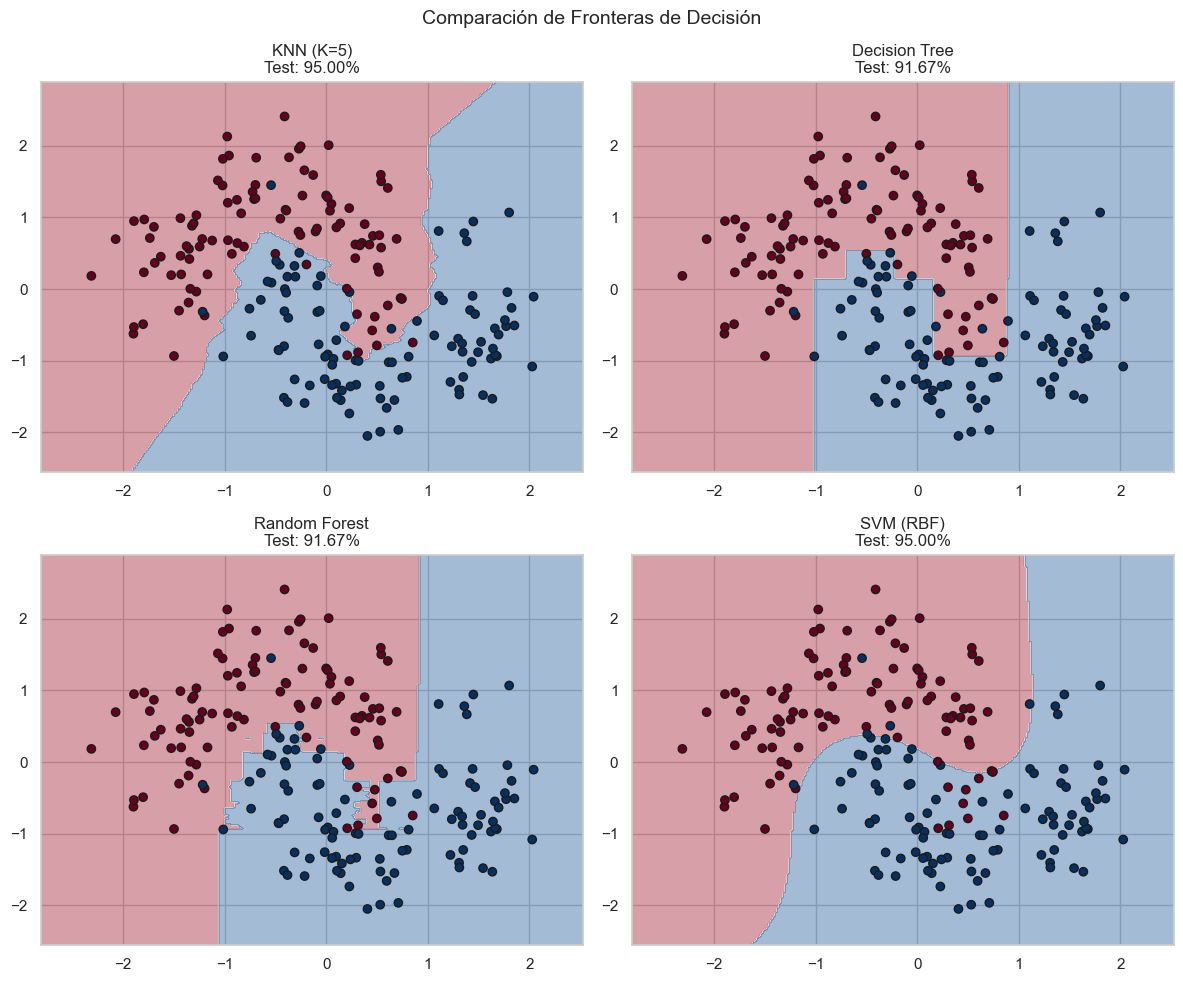

In [17]:
# Visualizar fronteras de todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.flat, models.items()):
    h = 0.02
    x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
    y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1],
               c=y_moons, cmap='RdBu', edgecolors='k')
    ax.set_title(f'{name}\nTest: {model.score(X_ts, y_ts):.2%}')

plt.suptitle('Comparación de Fronteras de Decisión', fontsize=14)
plt.tight_layout()
plt.show()


---

## 6. La Maldición de la Dimensionalidad

### ¿Por Qué KNN Falla en Alta Dimensión?

En espacios de alta dimensión:
1. **Todos los puntos están "lejos"** unos de otros
2. El concepto de "vecino más cercano" pierde significado
3. Se necesitan exponencialmente más datos para cubrir el espacio

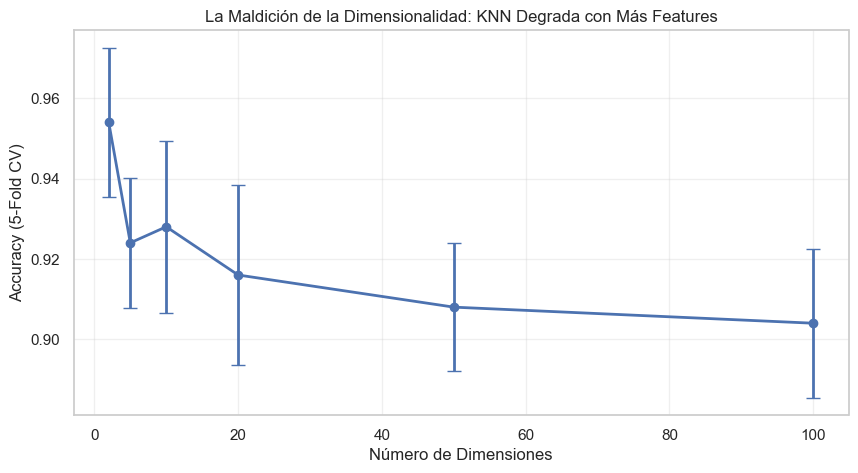

📉 A medida que aumentan las dimensiones, KNN pierde efectividad.
💡 Solución: Reducción de dimensionalidad (PCA) antes de KNN.


In [18]:
# Demostración: KNN vs dimensionalidad
dimensions = [2, 5, 10, 20, 50, 100]
results_dim = []

for d in dimensions:
    # Generar datos en d dimensiones
    X_d, y_d = make_classification(n_samples=500, n_features=d, n_informative=d,
                                   n_redundant=0, random_state=RANDOM_STATE)

    # Escalar
    X_d_scaled = StandardScaler().fit_transform(X_d)

    # Cross-validation
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, X_d_scaled, y_d, cv=5)

    results_dim.append({
        'Dimensiones': d,
        'Accuracy': np.mean(scores),
        'Std': np.std(scores)
    })

df_dim = pd.DataFrame(results_dim)

plt.figure(figsize=(10, 5))
plt.errorbar(df_dim['Dimensiones'], df_dim['Accuracy'],
             yerr=df_dim['Std'], marker='o', linewidth=2, capsize=5)
plt.xlabel('Número de Dimensiones')
plt.ylabel('Accuracy (5-Fold CV)')
plt.title('La Maldición de la Dimensionalidad: KNN Degrada con Más Features')
plt.grid(True, alpha=0.3)
plt.show()

print("📉 A medida que aumentan las dimensiones, KNN pierde efectividad.")
print("💡 Solución: Reducción de dimensionalidad (PCA) antes de KNN.")


> **⚠️ Real-World Warning: KNN en Producción**
> - **Memoria:** Almacena TODOS los datos de entrenamiento
> - **Latencia:** Cada predicción recorre todos los puntos
> - **Solución para escala:** Usar estructuras como KD-Tree o Ball-Tree (sklearn lo hace automático)

---

## 7. Caso de Negocio: Sistema de Recomendación Simple

KNN es la base de muchos sistemas de recomendación "Collaborative Filtering".

In [19]:
# Simular datos de usuarios y productos
np.random.seed(RANDOM_STATE)

# 100 usuarios, 20 productos (ratings 1-5 o NaN)
n_users = 100
n_products = 20

# Crear perfiles de usuario (features latentes)
user_profiles = np.random.rand(n_users, 5)  # 5 features latentes
product_profiles = np.random.rand(n_products, 5)

# Ratings = producto punto entre perfiles (+ ruido)
ratings = np.dot(user_profiles, product_profiles.T) * 4 + 1  # Escala 1-5
ratings += np.random.randn(n_users, n_products) * 0.5
ratings = np.clip(ratings, 1, 5).round(1)

# Simular ratings faltantes (70% observados)
mask = np.random.rand(n_users, n_products) < 0.7
ratings_sparse = np.where(mask, ratings, np.nan)

df_ratings = pd.DataFrame(ratings_sparse,
                          index=[f'User_{i}' for i in range(n_users)],
                          columns=[f'Prod_{j}' for j in range(n_products)])

print("📊 Matriz de Ratings (con NaN = no visto):")
df_ratings.head()


📊 Matriz de Ratings (con NaN = no visto):


,Prod_0,Prod_1,Prod_2,Prod_3,Prod_4,Prod_5,Prod_6,Prod_7,Prod_8,Prod_9,Prod_10,Prod_11,Prod_12,Prod_13,Prod_14,Prod_15,Prod_16,Prod_17,Prod_18,Prod_19
User_0,NaN,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,4.3,NaN,NaN,5.0,5.0,5.0,NaN,4.8,5.0
User_1,5.0,5.0,NaN,5.0,NaN,5.0,5.0,3.6,NaN,5.0,5.0,4.2,NaN,5.0,NaN,5.0,5.0,3.1,5.0,2.2
User_2,5.0,5.0,NaN,5.0,NaN,3.5,5.0,5.0,4.5,5.0,5.0,2.5,2.3,NaN,NaN,4.9,5.0,1.9,4.9,3.9
User_3,4.7,5.0,5.0,4.6,NaN,NaN,5.0,NaN,NaN,4.9,5.0,2.6,NaN,NaN,5.0,4.5,5.0,1.1,3.9,NaN
User_4,5.0,NaN,NaN,NaN,5.0,4.1,5.0,4.4,5.0,5.0,4.6,3.9,4.0,5.0,NaN,NaN,4.9,2.2,4.6,3.2


In [20]:
# Recomendar para User_0 basándonos en usuarios similares
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

# Imputar valores faltantes con la media (para calcular similitud)
imputer = SimpleImputer(strategy='mean')
ratings_imputed = imputer.fit_transform(ratings_sparse)

# Encontrar 5 usuarios similares a User_0
# 6 porque incluye a sí mismo
knn_rec = NearestNeighbors(n_neighbors=6, metric='cosine')
knn_rec.fit(ratings_imputed)

distances, indices = knn_rec.kneighbors([ratings_imputed[0]])
similar_users = indices[0][1:]  # Excluir User_0

print(f"🔍 Usuarios similares a User_0: {[f'User_{i}' for i in similar_users]}")

# Recomendar productos que User_0 no ha visto pero sus vecinos sí
productos_no_vistos = np.where(np.isnan(ratings_sparse[0]))[0]

if len(productos_no_vistos) > 0:
    # Rating promedio de vecinos para productos no vistos
    pred_ratings = []
    for prod in productos_no_vistos:
        vecinos_ratings = ratings_imputed[similar_users, prod]
        pred_ratings.append((f'Prod_{prod}', np.mean(vecinos_ratings)))

    # Ordenar por rating predicho
    pred_ratings.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🎯 Top 5 Recomendaciones para User_0:")
    for prod, rating in pred_ratings[:5]:
        print(f"   {prod}: Rating predicho = {rating:.2f}")


🔍 Usuarios similares a User_0: ['User_10', 'User_82', 'User_59', 'User_90', 'User_37']

🎯 Top 5 Recomendaciones para User_0:
   Prod_6: Rating predicho = 5.00
   Prod_8: Rating predicho = 4.99
   Prod_4: Rating predicho = 4.98
   Prod_0: Rating predicho = 4.95
   Prod_13: Rating predicho = 4.94


### 🧠 Micro-Desafío: Limitaciones del Enfoque

**Reflexiona:**
1. ¿Qué pasa con usuarios nuevos (sin ratings)? → **Cold Start Problem**
2. ¿Qué pasa si un usuario tiene gustos muy únicos? → **Sparsity Problem**
3. ¿Escala este enfoque a millones de usuarios? → **Scalability Problem**

**Soluciones modernas:** Matrix Factorization (SVD), Deep Learning (Neural Collaborative Filtering)

---

## 8. Resumen y Siguiente Paso

### 🏆 Resumen de Logros
¡Felicidades! En este notebook has aprendido:

1. **Lazy Learning:** KNN no entrena, solo memoriza y busca en predicción.
2. **Elección de K:** Balance entre overfitting (K bajo) y underfitting (K alto).
3. **Métricas de Distancia:** Euclidiana, Manhattan, y por qué importan.
4. **Escalado:** CRÍTICO para que las distancias tengan sentido.
5. **Maldición de la Dimensionalidad:** KNN sufre en alta dimensión.

### ✅ Cuándo Usar KNN
- Datasets pequeños/medianos (<50k muestras)
- Pocas dimensiones (<20 features)
- Cuando necesitas explicabilidad ("se parece a estos ejemplos")
- Sistemas de recomendación simples

### ⚠️ Cuándo Evitar KNN
- Datasets grandes (predicción lenta)
- Alta dimensionalidad
- Cuando la memoria es limitada

---

### 👉 Siguiente Paso
¡Has completado todos los algoritmos introductorios de la Sesión 2!

**Resumen de Modelos Cubiertos:**
- 🌳 Árboles de Decisión (CART)
- 🌲 Random Forest (Bagging)
- 🚀 Gradient Boosting (XGBoost, LightGBM)
- 📐 Support Vector Machines (SVM)
- 🔍 K-Nearest Neighbors (KNN)

*En el notebook práctico `01_Algoritmos_No_Lineales.ipynb` aplicarás todos estos algoritmos a un dataset real de Churn.*